In [ ]:
%pip install datasets pandas matplotlib seaborn

In [2]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()

In [4]:
import json

data = []
with open("combined_dataset.json", "r") as f:
    for line in f:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Skipping line due to error: {e}")

In [ ]:
import pandas as pd

df = pd.DataFrame(data)
df.head()

In [ ]:
print(df.columns)
print(df.iloc[0])

In [ ]:
# Check dataset info
df.info()

In [ ]:
# Check for missing values
df.isnull().sum()

,0
Context,0
Response,0


In [ ]:
print(df.columns)

In [ ]:
import pprint
pprint.pprint(df.iloc[0], depth=3)

In [ ]:
df['context_length'] = df['Context'].apply(lambda x: len(x.split()))
df['response_length'] = df['Response'].apply(lambda x: len(x.split()))

df[['context_length', 'response_length']].describe()


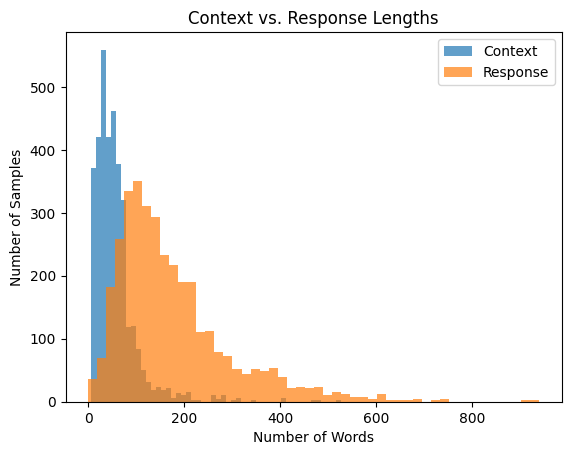

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df['context_length'], bins=50, alpha=0.7, label='Context')
plt.hist(df['response_length'], bins=50, alpha=0.7, label='Response')
plt.xlabel('Number of Words')
plt.ylabel('Number of Samples')
plt.title('Context vs. Response Lengths')
plt.legend()
plt.show()

In [ ]:
for i in range(5):
    print(f"\nContext: {df.iloc[i]['Context']}")
    print(f"Response: {df.iloc[i]['Response']}")

In [ ]:
# Get rows where response is empty (i.e., response_length == 0)
empty_responses_df = df[df['response_length'] == 0]

# Check how many there are
print(f"Number of entries with empty responses: {len(empty_responses_df)}")

# Optionally display the first few to inspect
empty_responses_df.head()

In [15]:
df = df[df['response_length'] > 0].reset_index(drop=True)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
print(f"Train size: {len(train_df)} | Validation size: {len(val_df)}")

In [ ]:
%pip install transformers datasets

In [18]:
from transformers import AutoTokenizer
import torch

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")

In [20]:
def tokenize_function(example):
    return tokenizer(
        example['Context'],
        text_target=example['Response'],  # Use text_pair for GPT-2/DialoGPT if needed
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

In [21]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")

# Set the pad token to the end-of-sequence token (common practice for GPT models)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Apply tokenizer
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)

In [23]:
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
import torch
print("GPU available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")